# 样题1

### 模块A 大数据运维与应用

##### 任务 1.1 配置hosts文件

`master,node1,node2`:

```shell
vim /etc/hosts


192.168.85.11 master
192.168.85.12 node1
192.168.85.13 node2

```

##### 任务1.2 修改 Hadoop 配置文件
`master,node1,node2`:

sudo vim ~/hadoop-2.9.2/etc/hadoop/hdfs-site.xml
```xml
<property>
        <name>dfs.replication</name>
        <value>2</value>
</property>

```

##### 任务1.3 启动Hadoop集群
`master`:


sudo start-all.sh

##### 任务2.1 HDFS上新建目录
`master`:

```shell
hdfs dfs -mkdir /dualcore
#用下面命令验证
hdfs dfs -ls /
```


##### 任务2.2 修改HDFS目录权限
`master`:
```shell
hdfs dfs -chmod -R 777  /dualcore
#用下面命令验证
hdfs dfs -ls /
```

##### 任务2.3 上传本地文件到HDFS上
`master`:
```shell
`master`:
hdfs dfs -put ~/data/loyalty_data.txt /dualcore/
#验证
hdfs dfs -ls /dualcore

```

##### 任务3.1 Sqoop 连接 Mysql并查询
`master`:

```shell
sqoop-eval \
--connect jdbc:mysql://node1/foshan_competition \
--username root \
--password 123456 \ 
--query "SELECT COUNT(DISTINCT order_item_product_id) FROM order_items" \
> ~/y_preds/task3-1.txt
#验证
cat  ~/y_preds/task3-1.txt

```

##### 任务3.2  Sqoop 导入
`master`:
```shell
sqoop-import \
--connect jdbc:mysql://node1/foshan_competition \
--username root \
--password 123456 \
--table products \
--hive-import \
--hive-database default 

#验证
hive
select * from default.products limit 3

```

##### 任务3.3 Sqoop导出
`master`:
```shell
sqoop-export \
--connect jdbc:mysql://node1/foshan_competition \
--username root \
--password 123456 \
--table customers \
--export-dir /sqoop/customers \
# 如果不能自动创建mysql表(报错mysql表不存在),需要手动创建表结构后在执行导出操作
create table customer(...)
#验证
mysql -uroot -p123456 -h node1
select * from foshan_competition.customers limit 3

```

##### 任务4.1 创建 Hive 外部表
`master`:
```sql
hive

CREATE EXTERNAL TABLE default.mobo ( 
    cust_id STRING,
    fname STRING,
    lname STRING,
    email STRING,
    level STRING,
    phone MAP<STRING, STRING>,
    order_ids ARRAY<STRING>,
    order_value STRUCT<min_val: DOUBLE, max_val: DOUBLE, avg_val: DOUBLE, total_val: DOUBLE>
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY '|'
COLLECTION ITEMS TERMINATED BY ','
MAP KEYS TERMINATED BY ':'
LOCATION '/dualcore/loyalty_data.txt';


```

##### 任务4.2 Hive 查询语句
```sql
#a.
hive -e "
SELECT phone['HOME'] AS home_phone
FROM default.loyalty_program
WHERE cust_id = '1200866'" > ~/results/task4-2.txt

#b
hive -e "
SELECT order_ids[2] AS third_order_id
FROM default.loyalty_program
WHERE cust_id = '1200866'" >> ~/results/task4-2.txt

#c
hive -e "
SELECT order_value.total_val AS total_order_value
FROM default.loyalty_program
WHERE cust_id = '1200866'
" >> ~/results/task4-2.txt


```

##### 任务4.3 分析数值产品评分
```sql
hive -e "
SELECT prod_id
FROM (
    SELECT prod_id, AVG(rating) AS avg_rating, COUNT(*) AS rating_count
    FROM ratings
    GROUP BY prod_id
    HAVING rating_count >= 50
) ranked_products
ORDER BY avg_rating DESC
LIMIT 1;
" > ~/results/task4-3.txt

```

##### 5.1 Flume 组件安装

```shell
#解压
tar -zxvf ~/hadoop搭建相关安装包/apache-flume-1.9.0-bin.tar.gz -C ~/
#配置环境变量
vim /etc/profile
export FLUME_HOME=~/apache-flume-1.9.0-bin
export PATH=$PATH:$FLUME_HOME/bin
source /etc/profile
#修改flume配置
vim ~/apache-flume-1.9.0-bin/conf/flume-env.sh
export JAVA_HOME=/opt/module/jdk
#复制依赖驱动
#比较hadoop的guava-xx.x.x.jar版本,保证和hadoop一致
```

##### 5.2 Flume 文件监控
```
a1.sources=r1
a1.sinks=k1
a1.channels=c1

a1.sources.r1.type=spooldir
a1.sources.r1.spoolDir=/home/ec2-user/flume
a1.sources.r1.basenameHeader=true

a1.sinks.k1.type=hdfs
a1.sinks.k1.hdfs.path=hdfs://node01:9000/flume
a1.sinks.k1.hdfs.filePrefix=%{basename}
a1.sinks.k1.hdfs.fileType=DataStream
a1.sinks.k1.hdfs.rollInterval=1
a1.sinks.k1.hdfs.rollSize=0
a1.sinks.k1.hdfs.rollCount=0

a1.channels.c1.type=memory

a1.sources.r1.channels=c1
a1.sinks.k1.channel=c1
```

##### 任务6 Spark 分布式计算
```scala
import org.apache.spark.sql.SparkSession
import org.apache.spark.sql.functions._

object Task6SparkDistributedComputing {
  def main(args: Array[String]): Unit = {
    val spark = SparkSession.builder()
      .appName("Task 6 - Spark Distributed Computing")
      .getOrCreate()

    // 6.1 计算不重复的电影数量
    val movieRatingsDF = spark.read
      .option("header", "true")
      .option("inferSchema", "true")
      
      .csv("hdfs://node01:9000/spark/movie_ratings.csv")

    val uniqueMoviesCount = movieRatingsDF.select("movieId").distinct().count()
    uniqueMoviesCount.write.text("~/results/task6-1.txt")

    // 6.2 计算电影平均评分
    val averageRating = movieRatingsDF.agg(avg(col("rating")).as("average_rating"))
    averageRating.select(format_number(col("average_rating"), 2).as("average_rating"))
      .write.text("~/results/task6-2.txt")

    // 6.3 计算用户在夜晚的评分总记录数
    // 将时间戳字段转换为小时，并添加一个新的时间段列
    val ratingsWithTimeOfDay = movieRatingsDF.withColumn("hourOfDay", hour(from_unixtime(col("timestamp"))))
      .withColumn("timeOfDay",
        when(col("hourOfDay").between(7, 11), "morning")
          .when(col("hourOfDay").between(12, 13), "lunch")
          .when(col("hourOfDay").between(14, 17), "afternoon")
          .when(col("hourOfDay").between(18, 23), "evening")
          .otherwise("night")
      )

    val eveningRatingsCount = ratingsWithTimeOfDay
      .filter(col("timeOfDay") === "evening")
      .groupBy("userId")
      .agg(count("*").as("evening_ratings_count"))
      .select(sum("evening_ratings_count").as("total_evening_ratings_count"))

    eveningRatingsCount.write.text("~/results/task6-3.txt")

    spark.stop()
  }
}
```

```python
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, avg, format_number, from_unixtime, hour, when

def main():
    spark = SparkSession.builder \
        .appName("Task 6 - Spark Distributed Computing") \
        .getOrCreate()

    # 6.1 计算不重复的电影数量
    movie_ratings_df = spark.read \
        .option("header", "true") \
        .option("inferSchema", "true") \
        .csv("hdfs://node01:9000/spark/movie_ratings.csv")

    unique_movies_count = movie_ratings_df.select("movieId").distinct().count()
    unique_movies_count.write.text("~/results/task6-1.txt")

    # 6.2 计算电影平均评分
    average_rating = movie_ratings_df.agg(avg(col("rating")).alias("average_rating"))
    average_rating.select(format_number(col("average_rating"), 2).alias("average_rating")) \
        .write.text("~/results/task6-2.txt")

    # 6.3 计算用户在夜晚的评分总记录数
    # 将时间戳字段转换为小时，并添加一个新的时间段列
    ratings_with_time_of_day = movie_ratings_df.withColumn("hourOfDay", hour(from_unixtime(col("timestamp"))))
    ratings_with_time_of_day = ratings_with_time_of_day.withColumn("timeOfDay",
        when(col("hourOfDay").between(7, 11), "morning")
            .when(col("hourOfDay").between(12, 13), "lunch")
            .when(col("hourOfDay").between(14, 17), "afternoon")
            .when(col("hourOfDay").between(18, 23), "evening")
            .otherwise("night")
    )

    evening_ratings_count = ratings_with_time_of_day \
        .filter(col("timeOfDay") == "evening") \
        .groupBy("userId") \
        .agg(count("*").alias("evening_ratings_count")) \
        .select(sum("evening_ratings_count").alias("total_evening_ratings_count"))

    evening_ratings_count.write.text("~/results/task6-3.txt")

    spark.stop()

if __name__ == "__main__":
    main()

```

### 模块B 电影数据分析

In [1]:
# 导入相关库
# 配置pip镜像,提高下载速度
# pip config set global.index-url https://pypi.tuna.tsinghua.edu.cn/simple
import numpy as np
import pandas as pd
import json
import wordcloud
from imageio.v2 import imread
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from collections import Counter
from pyecharts import options as opts
from pyecharts.charts import Pie, Bar, Line, Grid, Funnel
plt.rcParams['font.sans-serif'] = ['miSans']

'OK'


'OK'

In [2]:
# 准备数据
data1 = pd.read_csv('data/tmdb_5000_movies.csv')
data2 = pd.read_csv('data/tmdb_5000_credits.csv')
# 删除重复列 title,axis=1表示删除列,inplace=True表示覆盖原始数据
data1.drop("title", axis=1, inplace=True)
# 左连接
y_pred = pd.merge(data1, data2, left_on='id', right_on='movie_id', how='left')
# 输出movies.csv
y_pred.to_csv('data/data_out1.csv', index=False, encoding='utf-8')
'OK'


'OK'

In [3]:
# 任务1：数据读取
data = pd.read_csv("data/data_out1.csv")
data.head(5)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,vote_average,vote_count,movie_id,title,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,7.2,11800,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",6.9,4500,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,6.3,4466,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,7.6,9106,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",6.1,2124,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [4]:
# 任务2：数据处理

# 任务2-1 删除指定字段 二次执行会报错
data.drop(['homepage', 'original_title', 'overview', 'spoken_languages',
          'status', 'tagline', 'movie_id'], axis=1, inplace=True)
data.columns


Index(['budget', 'genres', 'id', 'keywords', 'original_language', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'vote_average', 'vote_count', 'title', 'cast',
       'crew'],
      dtype='object')

In [5]:
# 任务2-2 增加profit字段，该字段为每部电影的收益，具体要求如下
data['profit'] = data['revenue']-data['budget']
data.loc[:2, ['id', 'revenue', 'budget', 'profit']]


,id,revenue,budget,profit
0,19995,2787965087,237000000,2550965087
1,285,961000000,300000000,661000000
2,206647,880674609,245000000,635674609


In [6]:
# 任务2-3 处理runtime字段的缺失值
data.loc[data['id'].isin([370980, 459488]), 'runtime'] = [98, 81]
data.loc[data['id'].isin([370980, 459488]), ['runtime']]


,runtime
2656,98.0
4140,81.0


In [7]:
# 任务2-4 处理release_date字段的缺失值

data['release_date'].fillna('2014-06-01', inplace=True)
data['release_date'] = data['release_date'].str[0:4]
# 修改列名,只能执行一次
data.rename(columns={'release_date': 'year'}, inplace=True)

data['year'][:3]


0    2009
1    2007
2    2015
Name: year, dtype: object

In [8]:
# #任务2-5 分别对genres, keywords, production_companies, production_countries字段进行处理

# 定义字段列表
colList = ['genres', 'keywords',
           'production_companies', 'production_countries']
# 分割
data['genres'] = data['genres'].apply(
    lambda x: '|'.join([genre['name'] for genre in eval(x)]))
data['keywords'] = data['keywords'].apply(
    lambda x: '|'.join([keyword['name'] for keyword in eval(x)]))
data['production_companies'] = data['production_companies'].apply(
    lambda x: '|'.join([company['name'] for company in eval(x)]))
data['production_countries'] = data['production_countries'].apply(
    lambda x: '|'.join([country['name'] for country in eval(x)]))
# 显示数据
data[colList][:3]


,genres,keywords,production_companies,production_countries
0,Action|Adventure|Fantasy|Science Fiction,culture clash|future|space war|space colony|so...,Ingenious Film Partners|Twentieth Century Fox ...,United States of America|United Kingdom
1,Adventure|Fantasy|Action,ocean|drug abuse|exotic island|east india trad...,Walt Disney Pictures|Jerry Bruckheimer Films|S...,United States of America
2,Action|Adventure|Crime,spy|based on novel|secret agent|sequel|mi6|bri...,Columbia Pictures|Danjaq|B24,United Kingdom|United States of America


In [9]:
# 任务2.6 对crew字段进行处理
data['crew'] = data['crew'].apply(lambda x: '|'.join(
    [member['name'] for member in eval(x) if member['job'] == 'Director']))
data.rename(columns={'crew': 'director'}, inplace=True)
data['director'][:3]


0     James Cameron
1    Gore Verbinski
2        Sam Mendes
Name: director, dtype: object

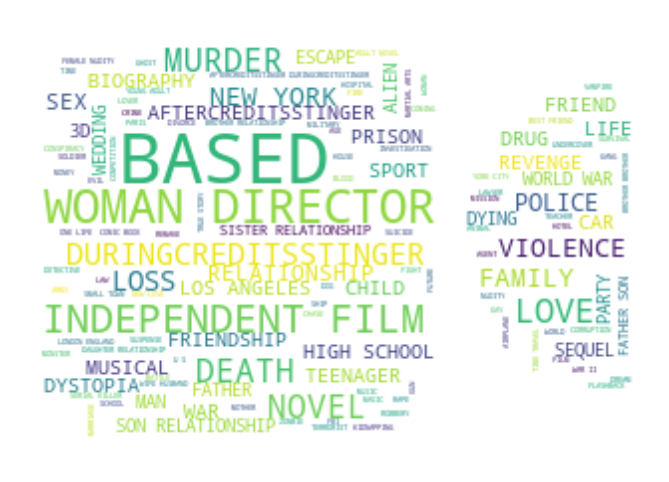

In [10]:
# 任务3.1 对电影的关键词制作词云图
# 准备数据
wordcloudData = ' '.join(data['keywords']).upper()
# 准备mask
maskImg = imread('img/video.png')
# 绘制词云图
plt.figure(figsize=(10, 6))
wordcloudImg = wordcloud.WordCloud(
    mask=maskImg, background_color="white").generate(wordcloudData)
plt.imshow(wordcloudImg, interpolation='bilinear')  # 用plt显示图片
plt.axis("off")  # 不显示坐标轴
plt.show()  # 显示图片


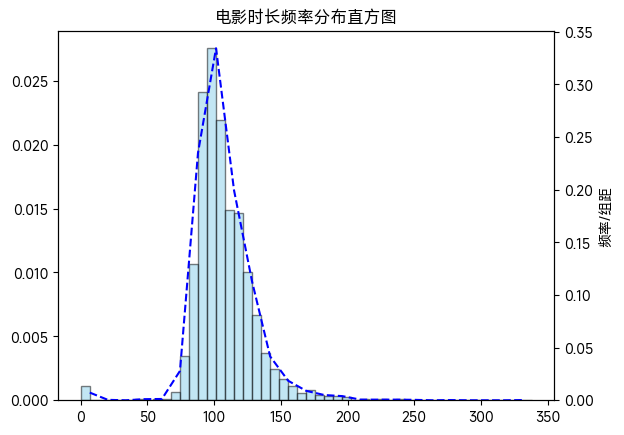

In [11]:
# 任务3.2 制作电影的时长频率分布直方图
runtime = [time for time in data['runtime']]

# # #绘制直方图  bins=显示柱形数,edgecolor=框线颜色,density=概率密度
plt.hist(runtime, bins=50, density=True,
         color='skyblue', alpha=0.5, edgecolor='black')
# 绘制概率密度曲线
ax2 = plt.gca().twinx()
ax2.set_ylabel('概率密度')
density, bins, _ = plt.hist(runtime, bins=25, density=True, alpha=0)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
density /= density.sum()
plt.plot(bin_centers, density, linestyle='dashed', color='blue')
plt.title('电影时长频率分布直方图')
plt.xlabel('电影时长')
plt.ylabel('频率/组距')
plt.show()


In [12]:
# 任务3.3 制作电影产地分布玫瑰图
# 获取产地列表
country_counts = data['production_countries'].str.split(
    '|', expand=True).stack().value_counts().drop("", axis=0)
# 将电影数量低于前五的产地归为'Others'
top5 = country_counts[:5]
top5['Others'] = country_counts[5:].sum()
labelData = top5.to_dict().keys()
valueData = top5.to_dict().values()
# #绘制玫瑰图
pie = (
    Pie(init_opts=opts.InitOpts(bg_color="white"))
    .add(
        "",
        [list(z) for z in zip(labelData, valueData)],
        radius=["20%", "85%"],
        rosetype="area",
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title="电影产地分布"),
        legend_opts=opts.LegendOpts(
            pos_top="2%", pos_left="15%", border_width=0),

    )
    .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}:{d}%"))
)
pie.render_notebook()


In [13]:
# 任务3.4 统计票房均值Top10的导演，并以条形图展示

# 统计票房均值Top10的导演
top10 = data.groupby('director')['revenue'].mean(
).sort_values(ascending=False).head(10)
# 绘制条形图
bar = (
    Bar()
    .add_xaxis(list(top10.index))
    .add_yaxis('', list(top10.values))
    .reversal_axis()
    .set_series_opts(label_opts=opts.LabelOpts(position="right"))
    .set_global_opts(title_opts=opts.TitleOpts(title='票房排名Top10的导演'),
                     )
)
grid = (
    Grid(init_opts=opts.InitOpts(bg_color="white", width="1200px"))
    .add(bar, grid_opts=opts.GridOpts(pos_left='25%'))
)
grid.render_notebook()


In [14]:
# 任务3.5 分析原创电影与改编电影在收益、票房、预算方面的表现，以旋风图展示：
# 计算原创电影和改编电影的收益、票房和预算
data['original_or_adaptation'] = data['genres'].apply(
    lambda x: 'Original' if 'Action' in x else 'Adaptation')
grouped_data = data.groupby('original_or_adaptation').agg({
    'revenue': 'mean',
    'profit': 'mean',
    'budget': 'mean'
}).reset_index()
grouped_data['revenue'] = round(grouped_data['revenue'] / 10000)
grouped_data['profit'] = round(grouped_data['profit'] / 10000)
grouped_data['budget'] = round(grouped_data['budget'] / 10000)

# 提取原创电影和改编电影的数据
valueData2 = [-grouped_data.loc[1, 'revenue'], -
              grouped_data.loc[1, 'profit'], -grouped_data.loc[1, 'budget']]
valueData = [grouped_data.loc[0, 'revenue'],
             grouped_data.loc[0, 'profit'], grouped_data.loc[0, 'budget']]

labelData = ['revenue', 'vote_count', 'budget']
# 绘制旋风图
bar = (
    Bar(init_opts=opts.InitOpts(bg_color="white"))
    .add_xaxis(labelData)
    .add_yaxis("改编", valueData, stack="stack1")
    .add_yaxis("原创", valueData2, stack="stack1")
    .reversal_axis()
    .set_series_opts(label_opts=opts.LabelOpts(is_show=True))

    .set_global_opts(
        title_opts=opts.TitleOpts(title="原创电影与改编电影对比图（万）"),
        legend_opts=opts.LegendOpts(pos_left="right"),
    )
)

bar.render_notebook()


In [15]:
# 任务3.6 统计各种电影类型所占的比例，以饼图展示
# 数据处理
genre_counts = data['genres'].str.split(
    '|', expand=True).stack().value_counts()

# 将比例小于1%的类型合并为'Other'类别
other_genres = genre_counts[genre_counts / genre_counts.sum() < 0.01].sum()
genre_counts = genre_counts[genre_counts / genre_counts.sum() >= 0.01]
genre_counts['Other'] = other_genres
labelData = genre_counts.to_dict().keys()
valueData = genre_counts.to_dict().values()
pie = (
    Pie(init_opts=opts.InitOpts(bg_color="white", width="1100px"))
    .add('', [list(z) for z in zip(labelData, valueData)])
    .set_global_opts(title_opts=opts.TitleOpts(title='各种电影类型所占的比例'),
                     legend_opts=opts.LegendOpts(
                         orient='vertical', pos_top='15%', pos_right='0%')
                     )
    .set_series_opts(label_opts=opts.LabelOpts(formatter='{b}:{d}%'),
                     itemstyle_opts=opts.ItemStyleOpts(
        border_color="white",  # 设置边框颜色为白色
        border_width=4,        # 设置边框宽度为2
    ),
    )
)
pie.render_notebook()


In [16]:
# 任务3.7# 过滤出1980年至今的电影数据


# 将'year'列转换为整数数据类型
data['year'] = data['year'].astype(int)
# 过滤出1980年至今的电影数据
recent_movies = data[data['year'] >= 1980]
# 统计电影类型Top5在不同年份的数量
genre_counts = recent_movies['genres'].str.get_dummies('|').sum()
top5_genres = genre_counts.nlargest(5).index.tolist()
# 以年份为索引，统计电影类型Top5在不同年份的数量
genre_counts_by_year = recent_movies.groupby('year')['genres'].apply(
    lambda x: x.str.get_dummies('|').sum()
).unstack().fillna(0)[top5_genres]

# 绘制折线图
line = (
    Line(init_opts=opts.InitOpts(bg_color="white"))
    .add_xaxis(genre_counts_by_year.index.astype(str).tolist())
    .set_global_opts(
        title_opts=opts.TitleOpts(title='电影风格Top5随时间的变化趋势(1980至今)'),
        legend_opts=opts.LegendOpts(pos_top='5%', pos_right="5%"),
    )
)
# 追加y轴数据
for genre in top5_genres:
    markpoint_opts = opts.MarkPointOpts(
        data=[opts.MarkPointItem(type_='max')]) if genre == 'Drama' else None
    line.add_yaxis(genre, genre_counts_by_year[genre].tolist(), is_smooth=True,
                   markpoint_opts=markpoint_opts,
                   label_opts=opts.LabelOpts(is_show=False))

line.render_notebook()


In [17]:
# 任务3.8 统计不同风格（类型）电影的收益能力，以条形图和折线图混合展示
GenresIncomeList = list(zip(data['genres'].map(lambda x: x.split(
    '|')), data['budget'], data['revenue'], data['revenue']-data['budget']))
GenresIncomeDict = {}
# GenresIncomeList
for item in GenresIncomeList:
    for ele in item[0]:
        if ele in GenresIncomeDict:
            GenresIncomeDict[ele][0] += item[1]
            GenresIncomeDict[ele][1] += item[3]
        else:
            GenresIncomeDict[ele] = [item[1], item[3]]
GenresIncomeDict.pop('')
for item in GenresIncomeDict:
    GenresIncomeDict[item][0] = GenresIncomeDict[item][1] / \
        GenresIncomeDict[item][0]
GenresIncomeList = list(GenresIncomeDict.items())
GenresIncomeList = sorted(
    GenresIncomeList, key=lambda x: x[1][1], reverse=True)
labelData = [item[0] for item in GenresIncomeList]
valueData2 = [item[1][0]*100 for item in GenresIncomeList]
valueData = [round(item[1][1]/100000000000, 2)
                      for item in GenresIncomeList]
# 绘制条形图


bar = (
    Bar(init_opts=opts.InitOpts(bg_color="white", width="1100px"))
    .add_xaxis(labelData)
    .add_yaxis("收益总和(亿)", valueData, label_opts=opts.LabelOpts(formatter="{c} 亿",))
    .set_series_opts(label_opts=opts.LabelOpts( position="top"))
    .extend_axis(
        yaxis=opts.AxisOpts(
            axislabel_opts=opts.LabelOpts(formatter="{value} %"),
            name="收益率(%)",
        )
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title='不同电影类型的收益率'),
        yaxis_opts=opts.AxisOpts(
            name="收益(百亿)",
        ),
    )
)
line = (
    Line()
    .add_xaxis(labelData)
    .add_yaxis("收益率(%)", valueData2, yaxis_index=1, label_opts=opts.LabelOpts(is_show=False),z_level=2)
)
bar.overlap(line)
bar.render_notebook()


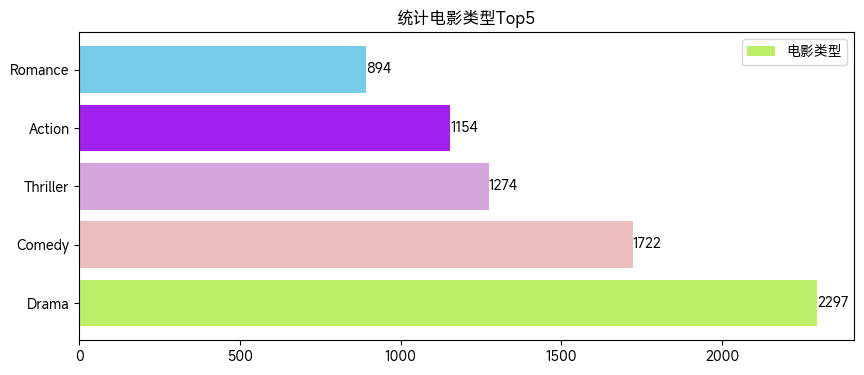

In [18]:
# 任务3.9 统计电影类型Top5，以条形图展示
# 获取电影类型列表


typeList = "|".join(data['genres']).split("|")
# 统计电影类型个数
typeCount = Counter(typeList)
# 获取类型前五(字典)
typeTop5 = sorted(typeCount.items(), key=lambda x: x[1], reverse=True)[:5]
# 拆分标签集和数据集
labelData = [label[0] for label in typeTop5]
valueData = [value[1] for value in typeTop5]

# 绘制条形图
# 定义颜色列表
colorList = ["#BCEE68", "#EBBDBF", "#D6A5DD", "#A020F0", "#76CBE8"]
plt.figure(figsize=(10, 4))  # 设置绘图大小
barh = plt.barh(labelData, valueData, color=colorList)
plt.bar_label(barh)
plt.legend(barh, ['电影类型'])
plt.title("统计电影类型Top5")
plt.show()


### 模块C 机器学习

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
plt.rcParams['font.sans-serif'] = ['miSans']


In [20]:
# 任务1 数据获取
data = pd.read_csv('data/credit_card_fraud.csv')
data.head(3)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


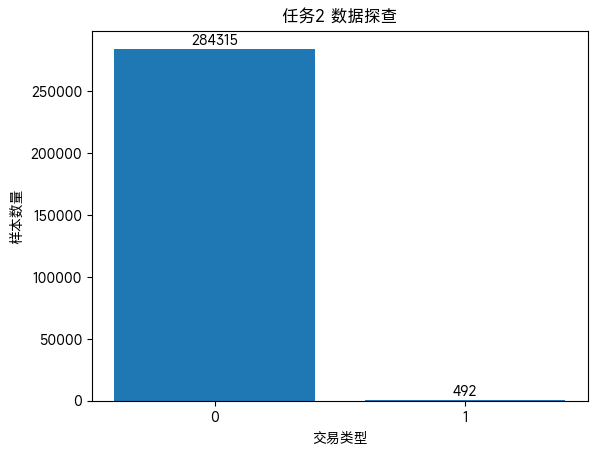

In [21]:
# 任务2 数据探查

# Class代表分类标签 0表示为欺诈   1 表示欺诈
# 将Class字段按属性值分别统计个数
countValue = pd.value_counts(data['Class'], sort=True)
countValue
xData = ['0', '1']
yData = [i for i in countValue]


# 绘制柱形图
barData = plt.bar(xData, yData)
plt.bar_label(barData)
plt.title("任务2 数据探查")
plt.xlabel("交易类型")
plt.ylabel("样本数量")
plt.show()

In [22]:
# 任务3 数据预处理与特征工程
# 任务3.1 标准化操作
# 将 data['Amount'] 中的数据转换为二维Numpy数组,
# 再进行归一化(标准化)处理
# 归一化（Normalization）是将数据按比例缩放，使其落入一个特定的范围，通常是 [0, 1] 或者 [-1, 1]
# data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data.drop('Time', axis=1, inplace=True)
data.head(5)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [23]:
# 任务3.2 下采样

# 计算出class==1（存在欺诈行为）次数
fraudCount = len(data[data.Class == 1])
# 取出class==1的欺诈行索引
fraudIndex = data[data.Class == 1].index
# 取出class==0的正常行索引
normalIndex = data[data.Class == 0].index

# 随机选择 和欺诈样本数相同的 标准样本 转换成numpy的格式 replace不允许重复
randomNormalIndex = np.random.choice(
    normalIndex, fraudCount, replace=False)
# 将class=0和1的样本的索引拼接在一起 下采样索引
underIndex = np.concatenate([fraudIndex, randomNormalIndex])

# #下采样的数据集
underData = data.loc[underIndex]

# 输出
print("下采样正常交易占比: ", len(randomNormalIndex)/len(underData))
print("下采样欺诈交易占比: ", len(fraudIndex)/len(underData))
print("下采样数据集样本总数: ", len(underData))


下采样正常交易占比:  0.5
下采样欺诈交易占比:  0.5
下采样数据集样本总数:  984


In [24]:
# 任务3.3 原数据集拆分为训练集与测试集
# 原数据拆分特征和标签 用于实例测试
X = data.drop('Class', axis=1)
y = data['Class']

# 下采样数据集拆分特征和标签
X_under = underData.drop('Class', axis=1)
y_under = underData['Class']
# 下取样的数据集拆分测试集和训练集 用于训练和测试
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(
    X_under, y_under, test_size=0.2, random_state=42)

print("下采样训练集样本数: ", len(X_train_under))
print("下采样测试集样本数: ", len(X_test_under))
print("下采样数据集样本总数: ", len(
    X_train_under)+len(X_test_under))

下采样训练集样本数:  787
下采样测试集样本数:  197
下采样数据集样本总数:  984


In [25]:
# 任务4 模型训练
# 4.1寻找最优惩罚参数


import warnings

warnings.filterwarnings("ignore")
'''
使用逻辑回归（Logistic Regression）算法构建分类模型的代码。

LogisticRegression: 表示使用逻辑回归算法构建分类模型。
C=best_c: C 是逻辑回归模型的正则化参数，控制模型的复杂度。best_c 是一个变量，代表了在训练过程中选择的最佳 C 值。
penalty='l1': penalty 是正则化策略，这里设置为 'l1' 表示使用 L1 正则化。L1 正则化可以帮助模型进行特征选择，使得模型更加简单。
solver='liblinear': solver 是求解优化问题的算法，这里选择了 'liblinear'。'liblinear' 是适用于 L1 正则化问题的求解器。
'''
model = LogisticRegression()
# 定义超参数网格
paramGrid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 1500],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 200, 300, 500]
}
# 网格搜索 寻找模型最佳参数并训练
grid_search = GridSearchCV(model, paramGrid, cv=5)
'''
fit(): 是逻辑回归模型中的一个方法，用于对模型进行训练。
X_train_under: 是用于训练模型的特征数据集，通常是一个二维数组或类似结构。
y_train_under.values.ravel(): 是用于训练模型的目标变量（标签），通常是一个一维数组。.values.ravel() 的作用是将目标变量转化为一维数组，以符合模型训练的要求。
'''
grid_search.fit(X_train_under, y_train_under)
print("最佳模型：", grid_search.best_estimator_)
print("最佳准确率：", grid_search.best_score_)  # 0.93


最佳模型： LogisticRegression(C=1, solver='newton-cg')
最佳准确率： 0.9478997016850761


准确率: 0.9593908629441624
精度: 0.9690721649484536
召回率: 0.9494949494949495
f1分数: 0.9591836734693878


Text(0.5, 1.0, '任务5 模型预测')

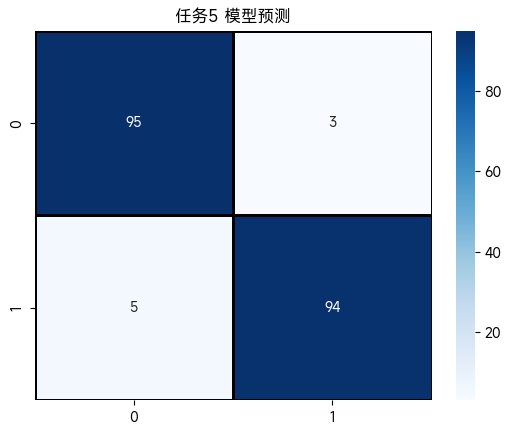

In [26]:
# 任务5 模型预测
# 加载最优模型
bestModel = grid_search.best_estimator_
'''
# 模型预测
lr.predict(): 是逻辑回归模型中的一个方法，用于对给定的特征数据进行预测。
X_test_under.values: 是用于预测的测试数据集，通常是一个二维数组或类似结构。
'''
y_pred = bestModel.predict(X_test_under)
# 计算混淆矩阵
matrix = confusion_matrix(y_test_under, y_pred)
'''
               预测为正例   预测为反例
真实标签为正例    TP         FN
真实标签为反例    FP         TN
其中：
TP（True Positive）表示模型正确地将正例预测为正例的数量。
FN（False Negative）表示模型错误地将正例预测为反例的数量。
FP（False Positive）表示模型错误地将反例预测为正例的数量。
TN（True Negative）表示模型正确地将反例预测为反例的数量。
'''
# 模型评估
print("准确率:", accuracy_score(y_test_under, y_pred))
print("精度:", precision_score(y_test_under, y_pred))
print("召回率:", recall_score(y_test_under, y_pred))
print("f1分数:", f1_score(y_test_under, y_pred))
sns.heatmap(matrix, annot=True, cmap='Blues',
            fmt='d', linecolor='black', linewidths=1)
plt.title("任务5 模型预测")


In [27]:
# 任务6 结果保存
X_test_under['result'] = y_pred
X_test_under.to_csv('data/result1.csv')
